In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, Circle
from scipy.ndimage import rotate, zoom
from astropy.io import fits
from astropy.visualization import wcsaxes
from astropy.wcs import WCS
import astropy.visualization as ax
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, aperture_photometry
from microfilm import colorify, microplot
from skimage import exposure
import scipy.optimize as opt
from mpl_toolkits.mplot3d import axes3d
from photutils.datasets import make_4gaussians_image
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset, zoomed_inset_axes)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Data

First, we make a list where all the images are saved.
In my case I have the 4 images from HST specified in Sect. 2 of the master thesis

In [2]:
path = 'C:\\Users\\pablo\\Desktop\\TFM\\data\\HST\\'    # Where we have the images in our device
fileList = sorted(glob.glob(path+'*.fits'))             # Sorting the list by name

images = []                                             # Loop for saving the data corresponding to each image in this list
for i in range(len(fileList)):
    # From each FITS we work on the 2nd element, which is the SCI
    hdu = fits.open(fileList[i])
    data = hdu[1].data
    images.append(data)

In [3]:
wHST = WCS(hdu[1].header) # This is the projection we'll use when ploting these images
                          # Make sure the transformation between pixel and celestial coordinates is the same for all images
                          # If not, you must have a wcs for each image

# Continuum subtracted images

Before subtracting the continuum image to the corresponding image captured with a narrow-filter, we have to calculate 
the factor that relates the fluxes of the wide and narrow-filter images. For that purpose, we obtain the flux of several 
standard stars in both images and do a linear regresion that gives us that factor. The tool used is DaoStarFinder.

## [FeII]

In [4]:
daofind_164 = DAOStarFinder(fwhm=3.0, threshold=4 * np.nanstd(images[3]))         # the threshold 4*std_164 results into 22 sources found
mask_164 = np.zeros(images[3].shape, dtype=bool) 
mask_164[700:775, 750:810] = True                                                 # This masks the jet that we see at first sight
sources_164 = daofind_164(images[3] - np.nanmedian(images[3]), mask=mask_164)     # 164 and 160 prefixes make allusion to the wavelgnth, 
                                                                                  # 1.64 and 1.60 microns respectively

positions_164 = np.transpose((sources_164['xcentroid'], sources_164['ycentroid']))
apertures_164 = CircularAperture(positions_164, r = 5.0)

region_164, region_160 = images[3], images[2]
phot_table_164 = aperture_photometry(region_164, apertures_164) 
phot_table_160 = aperture_photometry(region_160, apertures_164) 


In [5]:
# Delete the nan values
nan_indexes = []                                     # List where we save the positions of nan aperture_sum
for i in range(len(phot_table_164)):
    if np.isnan(phot_table_164[i]['aperture_sum']):
        nan_indexes.append(phot_table_164[i]['id'])
    elif np.isnan(phot_table_160[i]['aperture_sum']):
        nan_indexes.append(phot_table_160[i]['id'])

# Now we know the position of the nan values, we can proceed deleting that fluxes

counter = 0
while counter < len(phot_table_164):
    if phot_table_160[counter]['id'] in nan_indexes:
        del phot_table_164[counter]  
        del phot_table_160[counter]
    counter += 1

I decided to label some parameters with "large" and "short" as I'll obtain two pure emission images, one for Paschen beta 
and another for [FeII] at 1.64 microns. "Large" is for [FeII] and "short" for Pa$\beta$

In [6]:
x_large = phot_table_160['aperture_sum']
y_large = phot_table_164['aperture_sum']

# There are 3-4 stars that doesn't follow the tend and all of them correspond to the highest fluxes,
# so we discard them because the tendency might be different once a certain high value of the flow is reached

x_large_list, y_large_list = [], []
large_discarded_164, large_discarded_160 = [], []
for element in range(len(phot_table_164)):
    if x_large[element] < 70000:                   
        x_large_list.append(x_large[element])
        y_large_list.append(y_large[element])
    else: 
        large_discarded_164.append(phot_table_164[element])
        large_discarded_160.append(phot_table_160[element])

In [7]:
coefficients_large = np.polyfit(x_large_list, y_large_list, 1) 
region_160_resc = coefficients_large[0] * region_160
pure_large = region_164 - region_160_resc

This coefficient is the relation between the HST image at 1.60 microns with the one at 1.64;
and pure_large is the continuum subtracted image (so-called pure emission image) at the 
larger wavelength in this work

## Pa$\beta$

In [8]:
daofind_110 = DAOStarFinder(fwhm=3.0, threshold=20 * np.nanstd(images[0]))
mask_110 = np.zeros(images[0].shape, dtype=bool)
mask_110[700:775, 750:810] = True
sources_110 = daofind_110(images[0] - np.nanmedian(images[0]), mask=mask_110)

region_128 = images[1]
region_110 = images[0]
positions_110 = np.transpose((sources_110['xcentroid'], sources_110['ycentroid']))
apertures_110 = CircularAperture(positions_110, r = 5.0)

In [9]:
positions_128 = np.transpose((sources_110['xcentroid'], sources_110['ycentroid']))
apertures_128 = CircularAperture(positions_128, r = 5.0)
phot_table_128 = aperture_photometry(region_128, apertures_128) 
phot_table_110 = aperture_photometry(region_110, apertures_128) 

In [10]:
# These are stars that are very near to other star so their fluxes may be influenced by these other stars
del phot_table_128[0] 
del phot_table_110[0]

In [11]:
x_short = phot_table_110['aperture_sum']
y_short = phot_table_128['aperture_sum']

In [12]:
# Same scenario as before, there are 3-4 stars that doesn't follow the tend
x_short_list, y_short_list = [], []
short_discarded_110, short_discarded_128 = [], []
for element in range(len(x_short)):
    if x_short[element] < 100000:
        x_short_list.append(x_short[element])
        y_short_list.append(y_short[element])
    else:
        short_discarded_128.append(phot_table_128[element])
        short_discarded_110.append(phot_table_110[element])

In [13]:
coefficients_short = np.polyfit(x_short_list, y_short_list, 1)

region_110_resc = coefficients_short[0] * region_110
pure_short = region_128 - region_110_resc

This coefficient is the relation between the HST image at 1.10 microns with the one at 1.28;
and pure_short is the continuum subtracted image (so-called pure emission image) at the 
shorter wavelength in this work

## Check of the images obtained

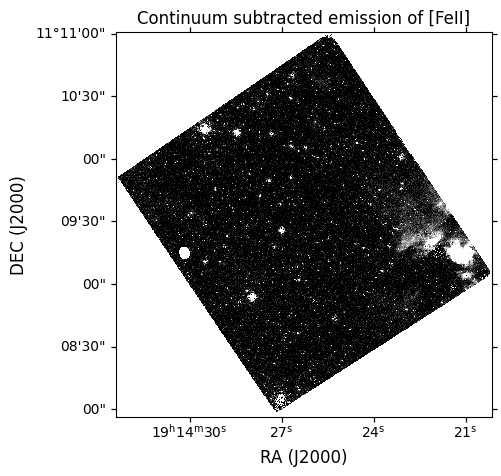

In [14]:
plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wHST)
plt.imshow(pure_short, cmap='gist_gray', origin='lower', vmin=0, vmax=0.2, interpolation='nearest')
plt.title('Continuum subtracted emission of [FeII]')
plt.xlabel('RA (J2000)', fontsize=12)
plt.ylabel('DEC (J2000)', fontsize=12)

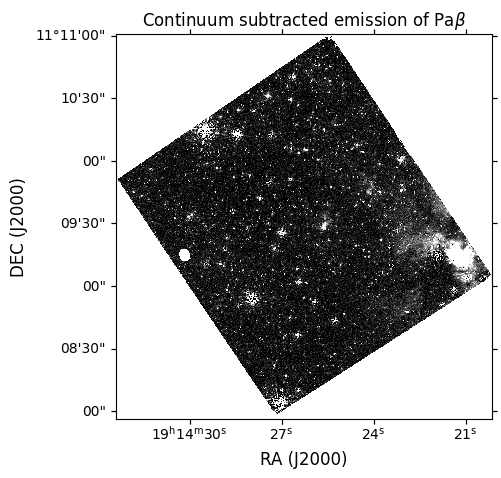

In [15]:
plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wHST)
plt.imshow(pure_large, cmap='gist_gray', origin='lower', vmin=0, vmax=0.2, interpolation='nearest')
plt.title(r'Continuum subtracted emission of Pa$\beta$')
plt.xlabel('RA (J2000)', fontsize=12)
plt.ylabel('DEC (J2000)', fontsize=12)

# Contour levels

See Sect. 3.6 of the thesis for further details. This code only contains the part corresponding to one of the two
regions where the contour levels have been computed, as the other is completely analogous.


Text(0.5, 1.0, '[FeII] - Squares with only background - Zone 1 ')

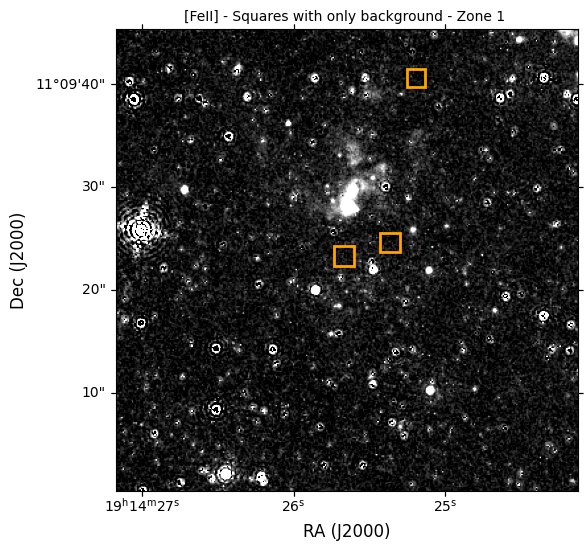

In [16]:
# This is to visualise regions with only background emission

rect1 = patches.Rectangle((165, 170), 15, 15, linewidth=2, edgecolor='orange', facecolor='none')
rect2 = patches.Rectangle((200, 180), 15, 15, linewidth=2, edgecolor='orange', facecolor='none')
rect3 = patches.Rectangle((220, 305), 14, 14, linewidth=2, edgecolor='orange', facecolor='none')

plt.figure(figsize=(7,6))
ax = plt.subplot(projection=wHST[500:850, 600:950])   # This is what makes the axis to be recongnized as celestial coordinates
plt.imshow(pure_large[500:850, 600:950], cmap = 'gist_gray', vmin = 0, vmax = 0.2, origin = 'lower')

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

plt.ylabel('Dec (J2000)', fontsize=12)
plt.xlabel('RA (J2000)', fontsize=12)
plt.title('[FeII] - Squares with only background - Zone 1 ', fontsize=10)

The std can be modified a bit depending on the regions we select, that's why we should take an average of some regions.
In our case we can find std between 0.016 and 0.024, hence the average value is around 0.02

In [17]:
pure_large_zoomed = pure_large[500:850, 600:950]
first_square_std = np.std(pure_large_zoomed[180:195, 201:216])
second_square_std = np.std(pure_large_zoomed[305:329, 220:234])
third_square_std = np.std(pure_large_zoomed[170:185, 167:182])
bkg_std_zone1 = np.nanmean([first_square_std, second_square_std, third_square_std])

In [18]:
# These are the levels of the contours:
levels_164_zone1 = [3*bkg_std_zone1, 5*bkg_std_zone1, 10*bkg_std_zone1, 25*bkg_std_zone1]

(690.0, 820.0)

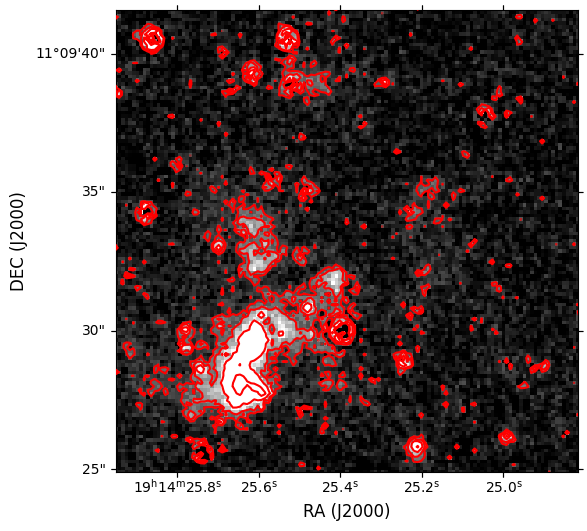

In [19]:
# Plot

plt.figure(figsize=(6,6))
ax = plt.subplot(projection=wHST)   # This is what makes the axis to be recongnized as celestial coordinates
plt.imshow(pure_large, cmap = 'gist_gray', vmin = 0, vmax = 0.2, origin = 'lower')    # Image
plt.contour(pure_large, colors='red', levels=levels_164_zone1)                        # Contours
plt.xlabel('RA (J2000)', fontsize='12')
plt.ylabel('DEC (J2000)', fontsize='12')

plt.xlim(740,870)
plt.ylim(690,820)


# Centroid

It can be simply computed with the next cell. 

In [20]:
# Example, subknot K2b
knot2b = pure_large[755:767, 772:787]
k2b_centroid_2d = centroid_2dg(knot2b)
k2b_centroid_coord = wHST[755:767, 772:787].pixel_to_world(k2b_centroid_2d[0], k2b_centroid_2d[1])

But if we want to visualise the gaussian fit we can do the following

In [21]:
# Define a 2D gaussian function
def gaussian_2d(xy, amp, x0, y0, sigma_x, sigma_y):
    x, y = xy
    return amp * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))


Text(0.5, 0.92, 'knot 2b')

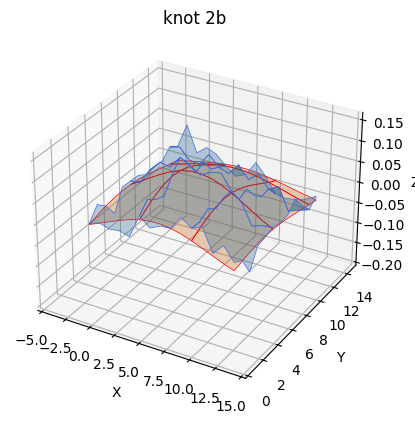

In [22]:
x = np.arange(0, knot2b.shape[1])
y = np.arange(0, knot2b.shape[0])
X, Y = np.meshgrid(x, y)

# Adjust the 2D gaussian to the image data
initial_guess = (np.max(knot2b), knot2b.shape[1] / 2, knot2b.shape[0] / 2, 10, 10)  # Ajuste inicial
popt, pcov = opt.curve_fit(gaussian_2d, (X.ravel(), Y.ravel()), knot2b.ravel(), p0=initial_guess)

# Extract the fit parameters
amp, x0, y0, sigma_x, sigma_y = popt

# Compute the 2D gaussian in the same grid than the knot's surface
gaussian_fit = gaussian_2d((X, Y), *popt)

# Create figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# knot2b
ax.plot_surface(X, Y, knot2b, edgecolor='royalblue', lw=0.5, rstride=5, cstride=5, alpha=0.3)

# 2D gaussian fit
ax.plot_surface(X, Y, gaussian_fit, edgecolor='red', lw=0.5, rstride=5, cstride=5, alpha=0.3)

# Limits and axis
ax.set(xlim=(-5, 15), ylim=(0, 15), zlim=(-0.2, 0.16),
       xlabel='X', ylabel='Y', zlabel='Z')

plt.title('knot 2b')


# Distance between source and knot
We can transform between pixel units and celestial coordinates with "world_to_pixel" and "pixel_to_world"
Here I'm going to get the location of the main source as I already know its coordinates

In [23]:
SC_skycoord_radiopeak = SkyCoord(ra='19:14:25.67', dec='11:9:25.45', unit=(u.hourangle, u.deg))  
SC_pixel_radiopeak = wHST.world_to_pixel(SC_skycoord_radiopeak)                      

In [24]:
sep2b = k2b_centroid_coord.separation(SC_skycoord_radiopeak)       # Separation between the centroid of the knot sand the source

k2b_centroid_2d = centroid_2dg(knot2b)

We use the relation 
\begin{equation}
X(au)=\alpha ('') \times d(pc)
\end{equation}
where d is the distance between us and the object

In [26]:
distance_to_knot2b = sep2b.arcsec* 8.4 * 10**3
print(f'The distance between our object and the knot 2b is {distance_to_knot2b} au')

The distance between our object and the knot 2b is 70201.0802498291 au
